# EHR XAI — Results Viewer

Reads already-saved outputs from `pipeline_out/` and presents them in a structured, side-by-side layout.  **No re-running required.**

Sections:
1. Setup — point to your output folder
2. Benchmark — AUC tables & comparison chart
3. Training curves — side-by-side per model
4. IG — global heatmaps & case studies
5. EG — global importance & temporal plots
6. EG — case studies
7. Counterfactuals — summaries & edit paths

---
## 1. Setup

> Set `OUT_DIR` and `SCENARIOS` to match your pipeline run. Everything else is automatic.

In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, HTML

# ── Point to your pipeline output folder ──────────────────────────────────────
OUT_DIR = "/home/hoepler/longitudinal_prediction_modeling/pipeline_out"

# ── Scenarios to include (subset or all) ──────────────────────────────────────
# Order here controls the display order throughout the notebook.
SCENARIOS = [
    "Baseline",
    "Small N",
    "Large N",
    "Rare Trigger",
    "Very Rare Trigger",
    "Short History",
    "Long History",
    "High Noise",
    "Very High Noise",
    "Stress Test",
]

# ── Models (must match names used during training) ─────────────────────────────
MODELS = ["GRU", "LSTM"]

# ── Helpers ───────────────────────────────────────────────────────────────────
def sc_dir(name):
    return os.path.join(OUT_DIR, name.replace(" ", "_"))

def sc_img(scenario, fname):
    return os.path.join(sc_dir(scenario), fname)

def exists(path):
    return os.path.exists(path)

def load_img(path):
    return mpimg.imread(path)

def show_grid(paths_and_titles, ncols=2, figsize_per=(8, 5), suptitle=None):
    """Display a grid of saved PNG files."""
    items = [(p, t) for p, t in paths_and_titles if exists(p)]
    if not items:
        print("  No images found.")
        return
    nrows = -(-len(items) // ncols)
    fig, axes = plt.subplots(nrows, ncols,
                              figsize=(figsize_per[0]*ncols, figsize_per[1]*nrows))
    axes = np.array(axes).flatten()
    for ax, (path, title) in zip(axes, items):
        ax.imshow(load_img(path))
        ax.set_title(title, fontsize=11, fontweight="bold")
        ax.axis("off")
    for ax in axes[len(items):]:
        ax.axis("off")
    if suptitle:
        fig.suptitle(suptitle, fontsize=14, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.show()

# Verify folders exist
missing = [s for s in SCENARIOS if not os.path.isdir(sc_dir(s))]
if missing:
    print(f"WARNING — folders not found: {missing}")
else:
    print(f"All {len(SCENARIOS)} scenario folders found in {OUT_DIR}")

All 10 scenario folders found in /home/hoepler/longitudinal_prediction_modeling/pipeline_out


---
## 2. Benchmark

### 2.1 Per-scenario AUC tables
One table per scenario showing all models.

In [2]:
all_bench = {}
for name in SCENARIOS:
    csv = os.path.join(sc_dir(name), "benchmark.csv")
    if exists(csv):
        df = pd.read_csv(csv)
        all_bench[name] = df
        print(f"\n── {name} ──")
        display(df.drop(columns="Scenario", errors="ignore")
                  .style.highlight_max(subset=["Test AUC"], color="#c8f0d0")
                  .highlight_min(subset=["Gap"],            color="#ffd0d0")
                  .format({"Train AUC": "{:.4f}", "Test AUC": "{:.4f}", "Gap": "{:.4f}"}))
    else:
        print(f"  {name}: benchmark.csv not found")


── Baseline ──


,Model,Train AUC,Test AUC,Gap
0,GRU,0.9091,0.8224,0.0866
1,LSTM,0.9002,0.8163,0.0839
2,Random Forest,0.9564,0.8152,0.1412
3,Logistic Regression,1.0000,0.7137,0.2863



── Small N ──


,Model,Train AUC,Test AUC,Gap
0,Logistic Regression,1.0000,0.6422,0.3578
1,Random Forest,0.9972,0.6214,0.3758
2,GRU,0.9819,0.5957,0.3863
3,LSTM,0.7916,0.5875,0.2040



── Large N ──


,Model,Train AUC,Test AUC,Gap
0,LSTM,0.8696,0.8374,0.0322
1,GRU,0.8828,0.8326,0.0503
2,Random Forest,0.8922,0.8049,0.0873
3,Logistic Regression,0.9630,0.7494,0.2136



── Rare Trigger ──


,Model,Train AUC,Test AUC,Gap
0,LSTM,0.8609,0.6737,0.1872
1,Random Forest,0.9116,0.6504,0.2612
2,GRU,0.6945,0.6435,0.0509
3,Logistic Regression,1.0000,0.6188,0.3812



── Very Rare Trigger ──


,Model,Train AUC,Test AUC,Gap
0,LSTM,0.7512,0.6899,0.0613
1,GRU,0.7439,0.6808,0.0631
2,Random Forest,0.9092,0.6344,0.2747
3,Logistic Regression,1.0000,0.5675,0.4325



── Short History ──


,Model,Train AUC,Test AUC,Gap
0,GRU,0.8991,0.8197,0.0794
1,LSTM,0.9165,0.8167,0.0998
2,Random Forest,0.9434,0.8000,0.1434
3,Logistic Regression,0.9921,0.7637,0.2283



── Long History ──


,Model,Train AUC,Test AUC,Gap
0,Random Forest,0.9681,0.7255,0.2426
1,Logistic Regression,1.0000,0.7120,0.2880
2,LSTM,0.6612,0.6140,0.0472
3,GRU,0.6226,0.6076,0.0149



── High Noise ──


,Model,Train AUC,Test AUC,Gap
0,GRU,0.9975,0.7318,0.2658
1,LSTM,0.8811,0.7006,0.1805
2,Random Forest,0.9999,0.6626,0.3373
3,Logistic Regression,1.0000,0.6113,0.3887



── Very High Noise ──


,Model,Train AUC,Test AUC,Gap
0,LSTM,0.9989,0.6197,0.3793
1,Random Forest,1.0000,0.6170,0.3830
2,GRU,1.0000,0.6150,0.3850
3,Logistic Regression,1.0000,0.5506,0.4494



── Stress Test ──


,Model,Train AUC,Test AUC,Gap
0,GRU,0.8777,0.6551,0.2225
1,LSTM,0.7743,0.6345,0.1397
2,Random Forest,0.9993,0.5898,0.4094
3,Logistic Regression,1.0000,0.5703,0.4297


### 2.2 Cross-scenario AUC pivot

In [3]:
if all_bench:
    comparison = pd.concat(all_bench.values(), ignore_index=True)
    pivot = (comparison
             .pivot_table(index="Scenario", columns="Model", values="Test AUC")
             .round(4))
    pivot.columns.name = None
    pivot = pivot.reindex([s for s in SCENARIOS if s in pivot.index])

    display(pivot.style
            .background_gradient(cmap="YlGn", axis=None)
            .format("{:.4f}"))

,GRU,LSTM,Logistic Regression,Random Forest
Scenario,,,,
Baseline,0.8224,0.8163,0.7137,0.8152
Small N,0.5957,0.5875,0.6422,0.6214
Large N,0.8326,0.8374,0.7494,0.8049
Rare Trigger,0.6435,0.6737,0.6188,0.6504
Very Rare Trigger,0.6808,0.6899,0.5675,0.6344
Short History,0.8197,0.8167,0.7637,0.8000
Long History,0.6076,0.6140,0.7120,0.7255
High Noise,0.7318,0.7006,0.6113,0.6626
Very High Noise,0.6150,0.6197,0.5506,0.6170


### 2.3 Comparison bar chart

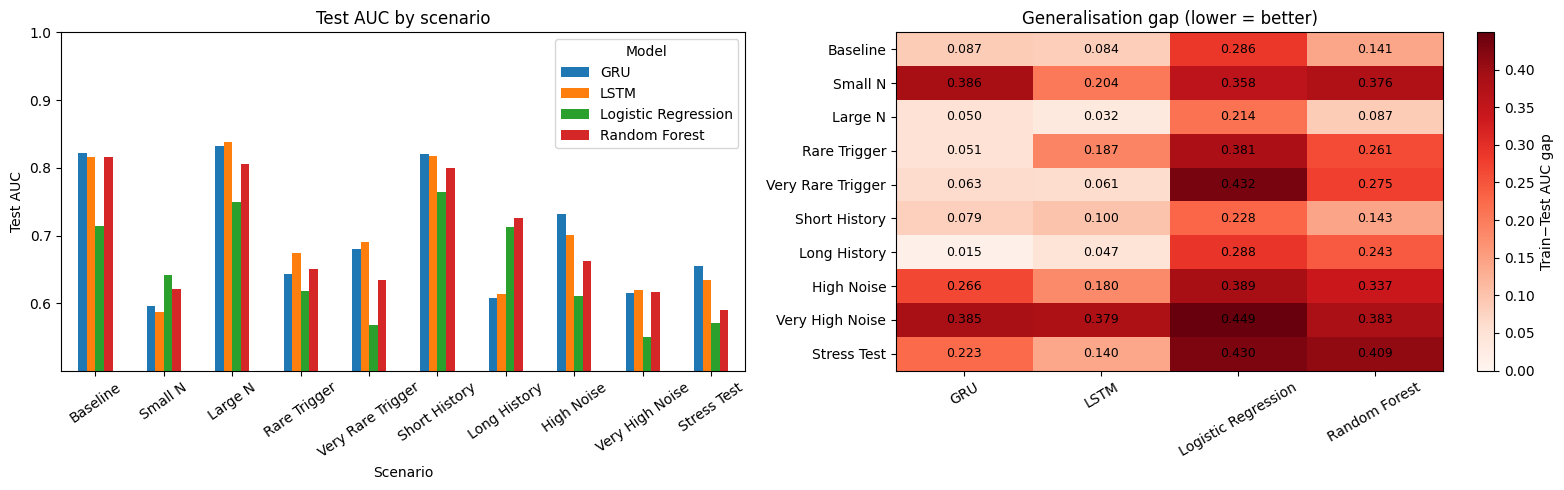

In [4]:
if all_bench:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Bar chart — Test AUC per scenario per model
    pivot.plot(kind="bar", ax=axes[0], rot=35)
    axes[0].set_ylabel("Test AUC")
    axes[0].set_title("Test AUC by scenario")
    axes[0].legend(title="Model")
    axes[0].set_ylim(max(0, pivot.values.min() - 0.05), 1.0)

    # Gap (Train - Test) heat: shows overfitting
    gap_pivot = (comparison
                 .pivot_table(index="Scenario", columns="Model", values="Gap")
                 .round(4))
    gap_pivot.columns.name = None
    gap_pivot = gap_pivot.reindex([s for s in SCENARIOS if s in gap_pivot.index])
    im = axes[1].imshow(gap_pivot.values, cmap="Reds", aspect="auto",
                        vmin=0, vmax=gap_pivot.values.max())
    axes[1].set_xticks(range(len(gap_pivot.columns)))
    axes[1].set_xticklabels(gap_pivot.columns, rotation=30)
    axes[1].set_yticks(range(len(gap_pivot.index)))
    axes[1].set_yticklabels(gap_pivot.index)
    for i in range(gap_pivot.shape[0]):
        for j in range(gap_pivot.shape[1]):
            axes[1].text(j, i, f"{gap_pivot.values[i,j]:.3f}",
                         ha="center", va="center", fontsize=9)
    plt.colorbar(im, ax=axes[1], label="Train−Test AUC gap")
    axes[1].set_title("Generalisation gap (lower = better)")

    plt.tight_layout()
    plt.show()

---
## 3. Training Curves

One row per model, one column per scenario. Change `SELECTED_SCENARIOS` to focus on a subset.

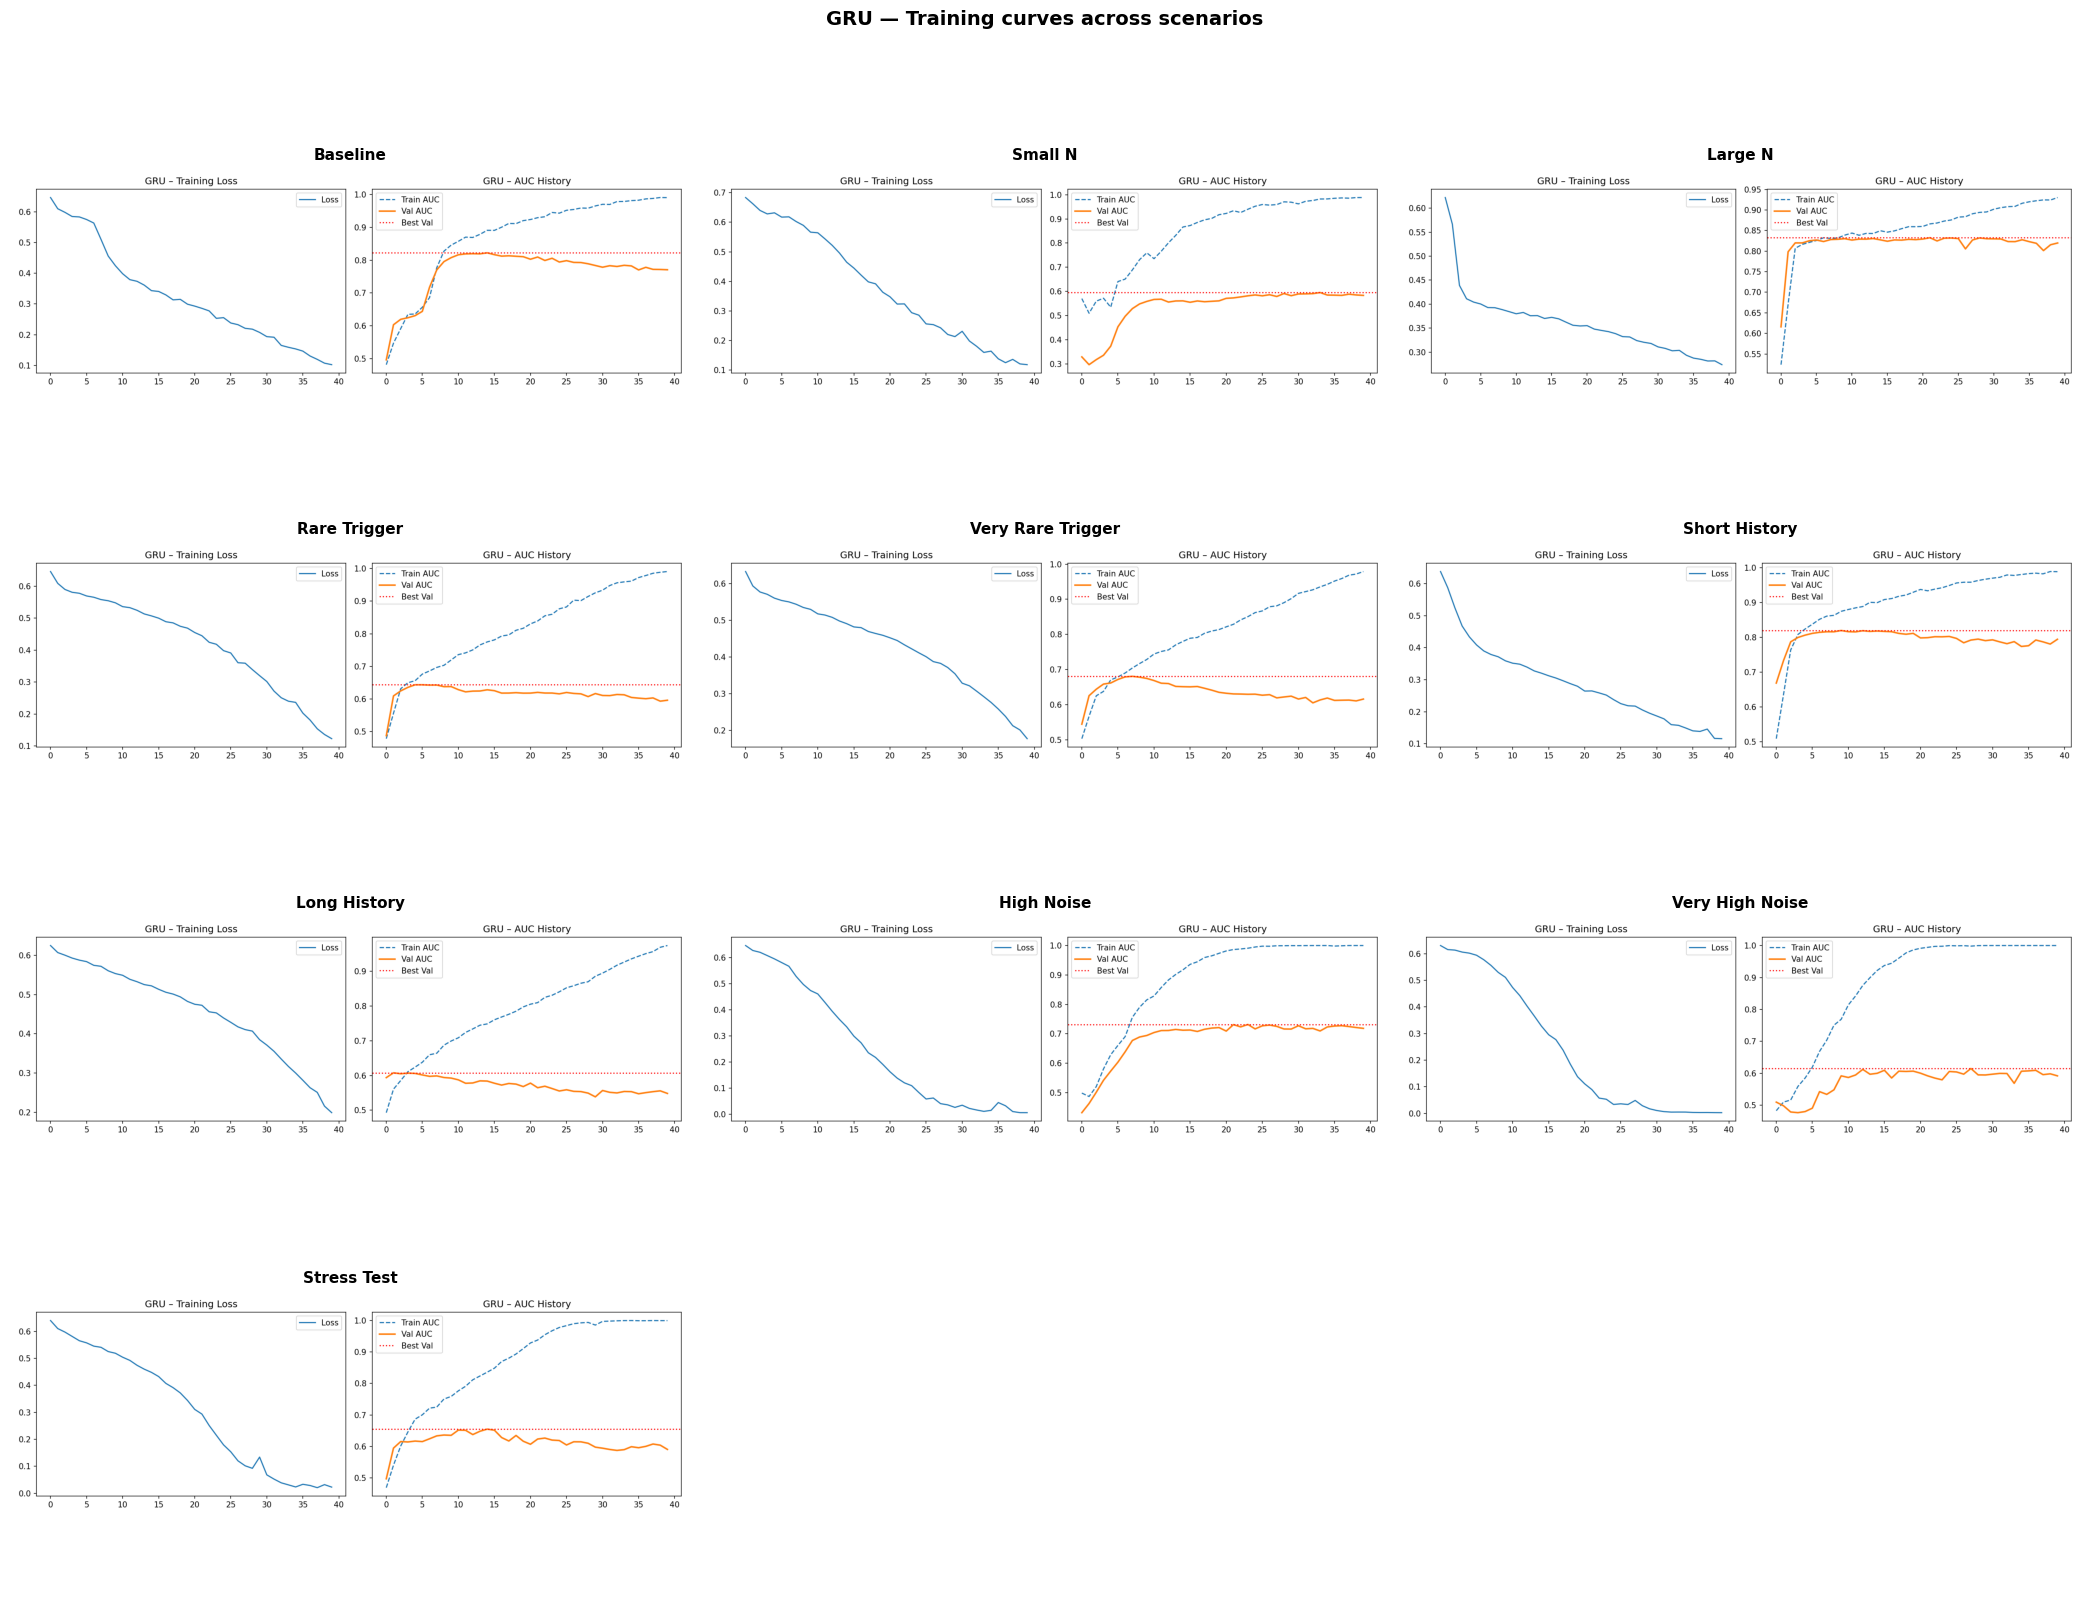

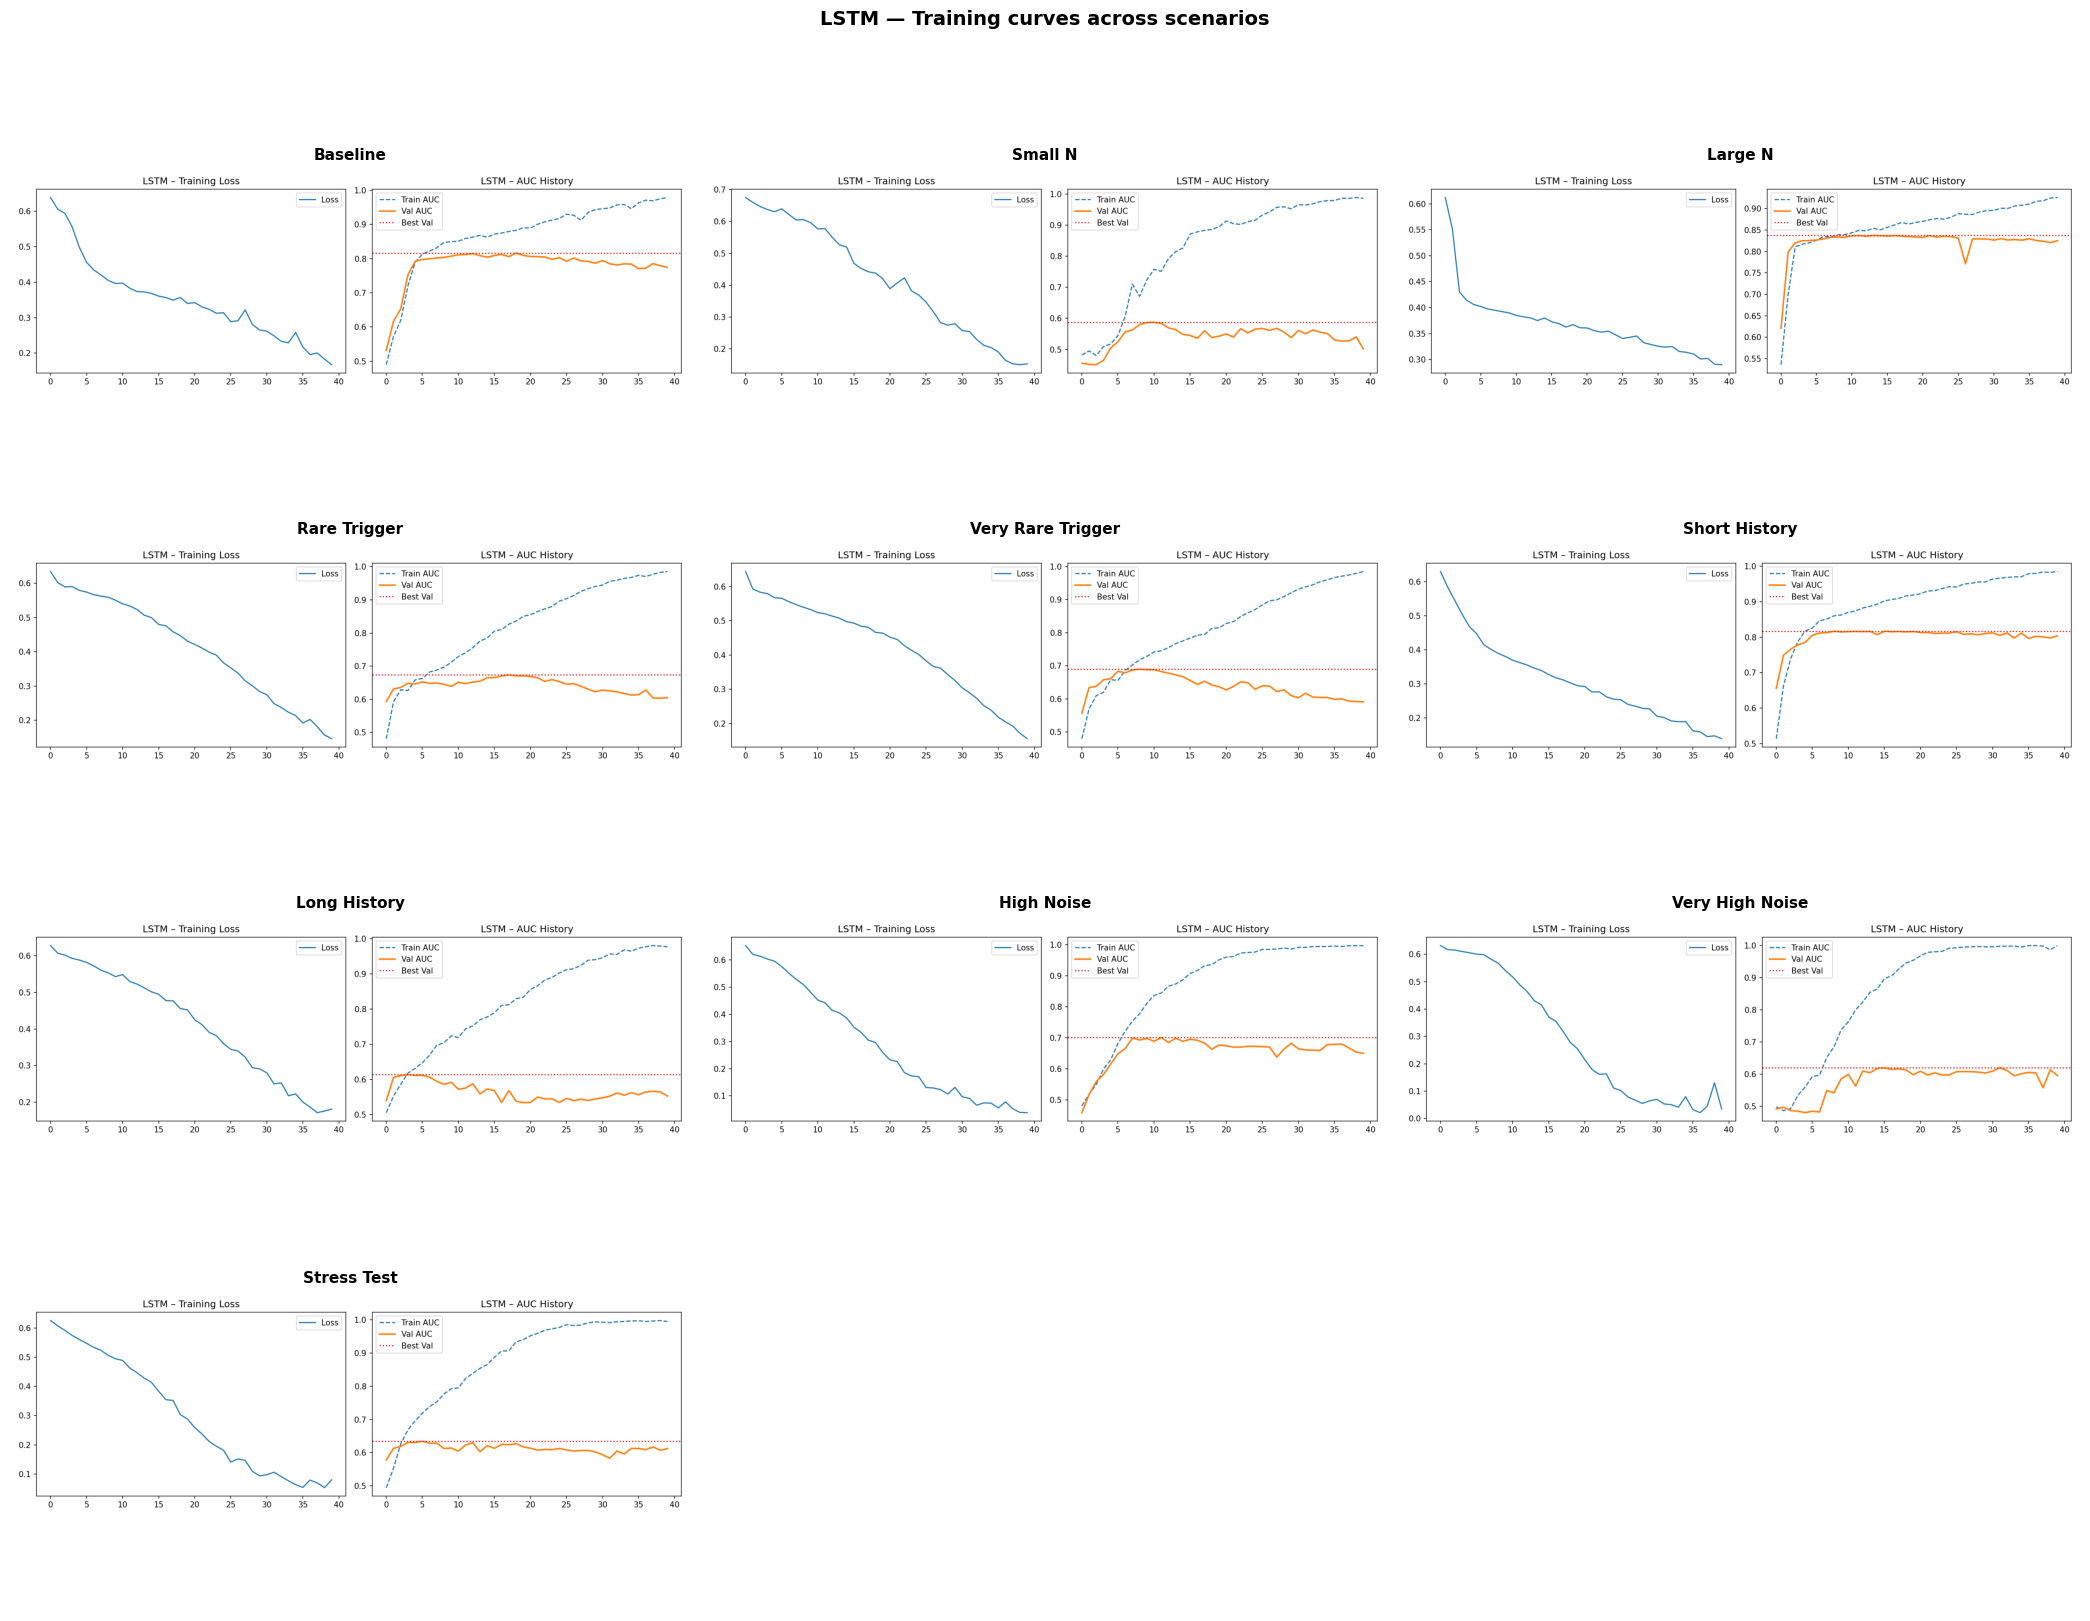

In [5]:
SELECTED_SCENARIOS = SCENARIOS   # ← narrow down here if needed

for model in MODELS:
    show_grid(
        [(sc_img(s, f"training_{model.lower()}.png"), s)
         for s in SELECTED_SCENARIOS],
        ncols=3, figsize_per=(7, 4),
        suptitle=f"{model} — Training curves across scenarios",
    )

---
## 4. Integrated Gradients (IG)

### 4.1 Global IG heatmaps

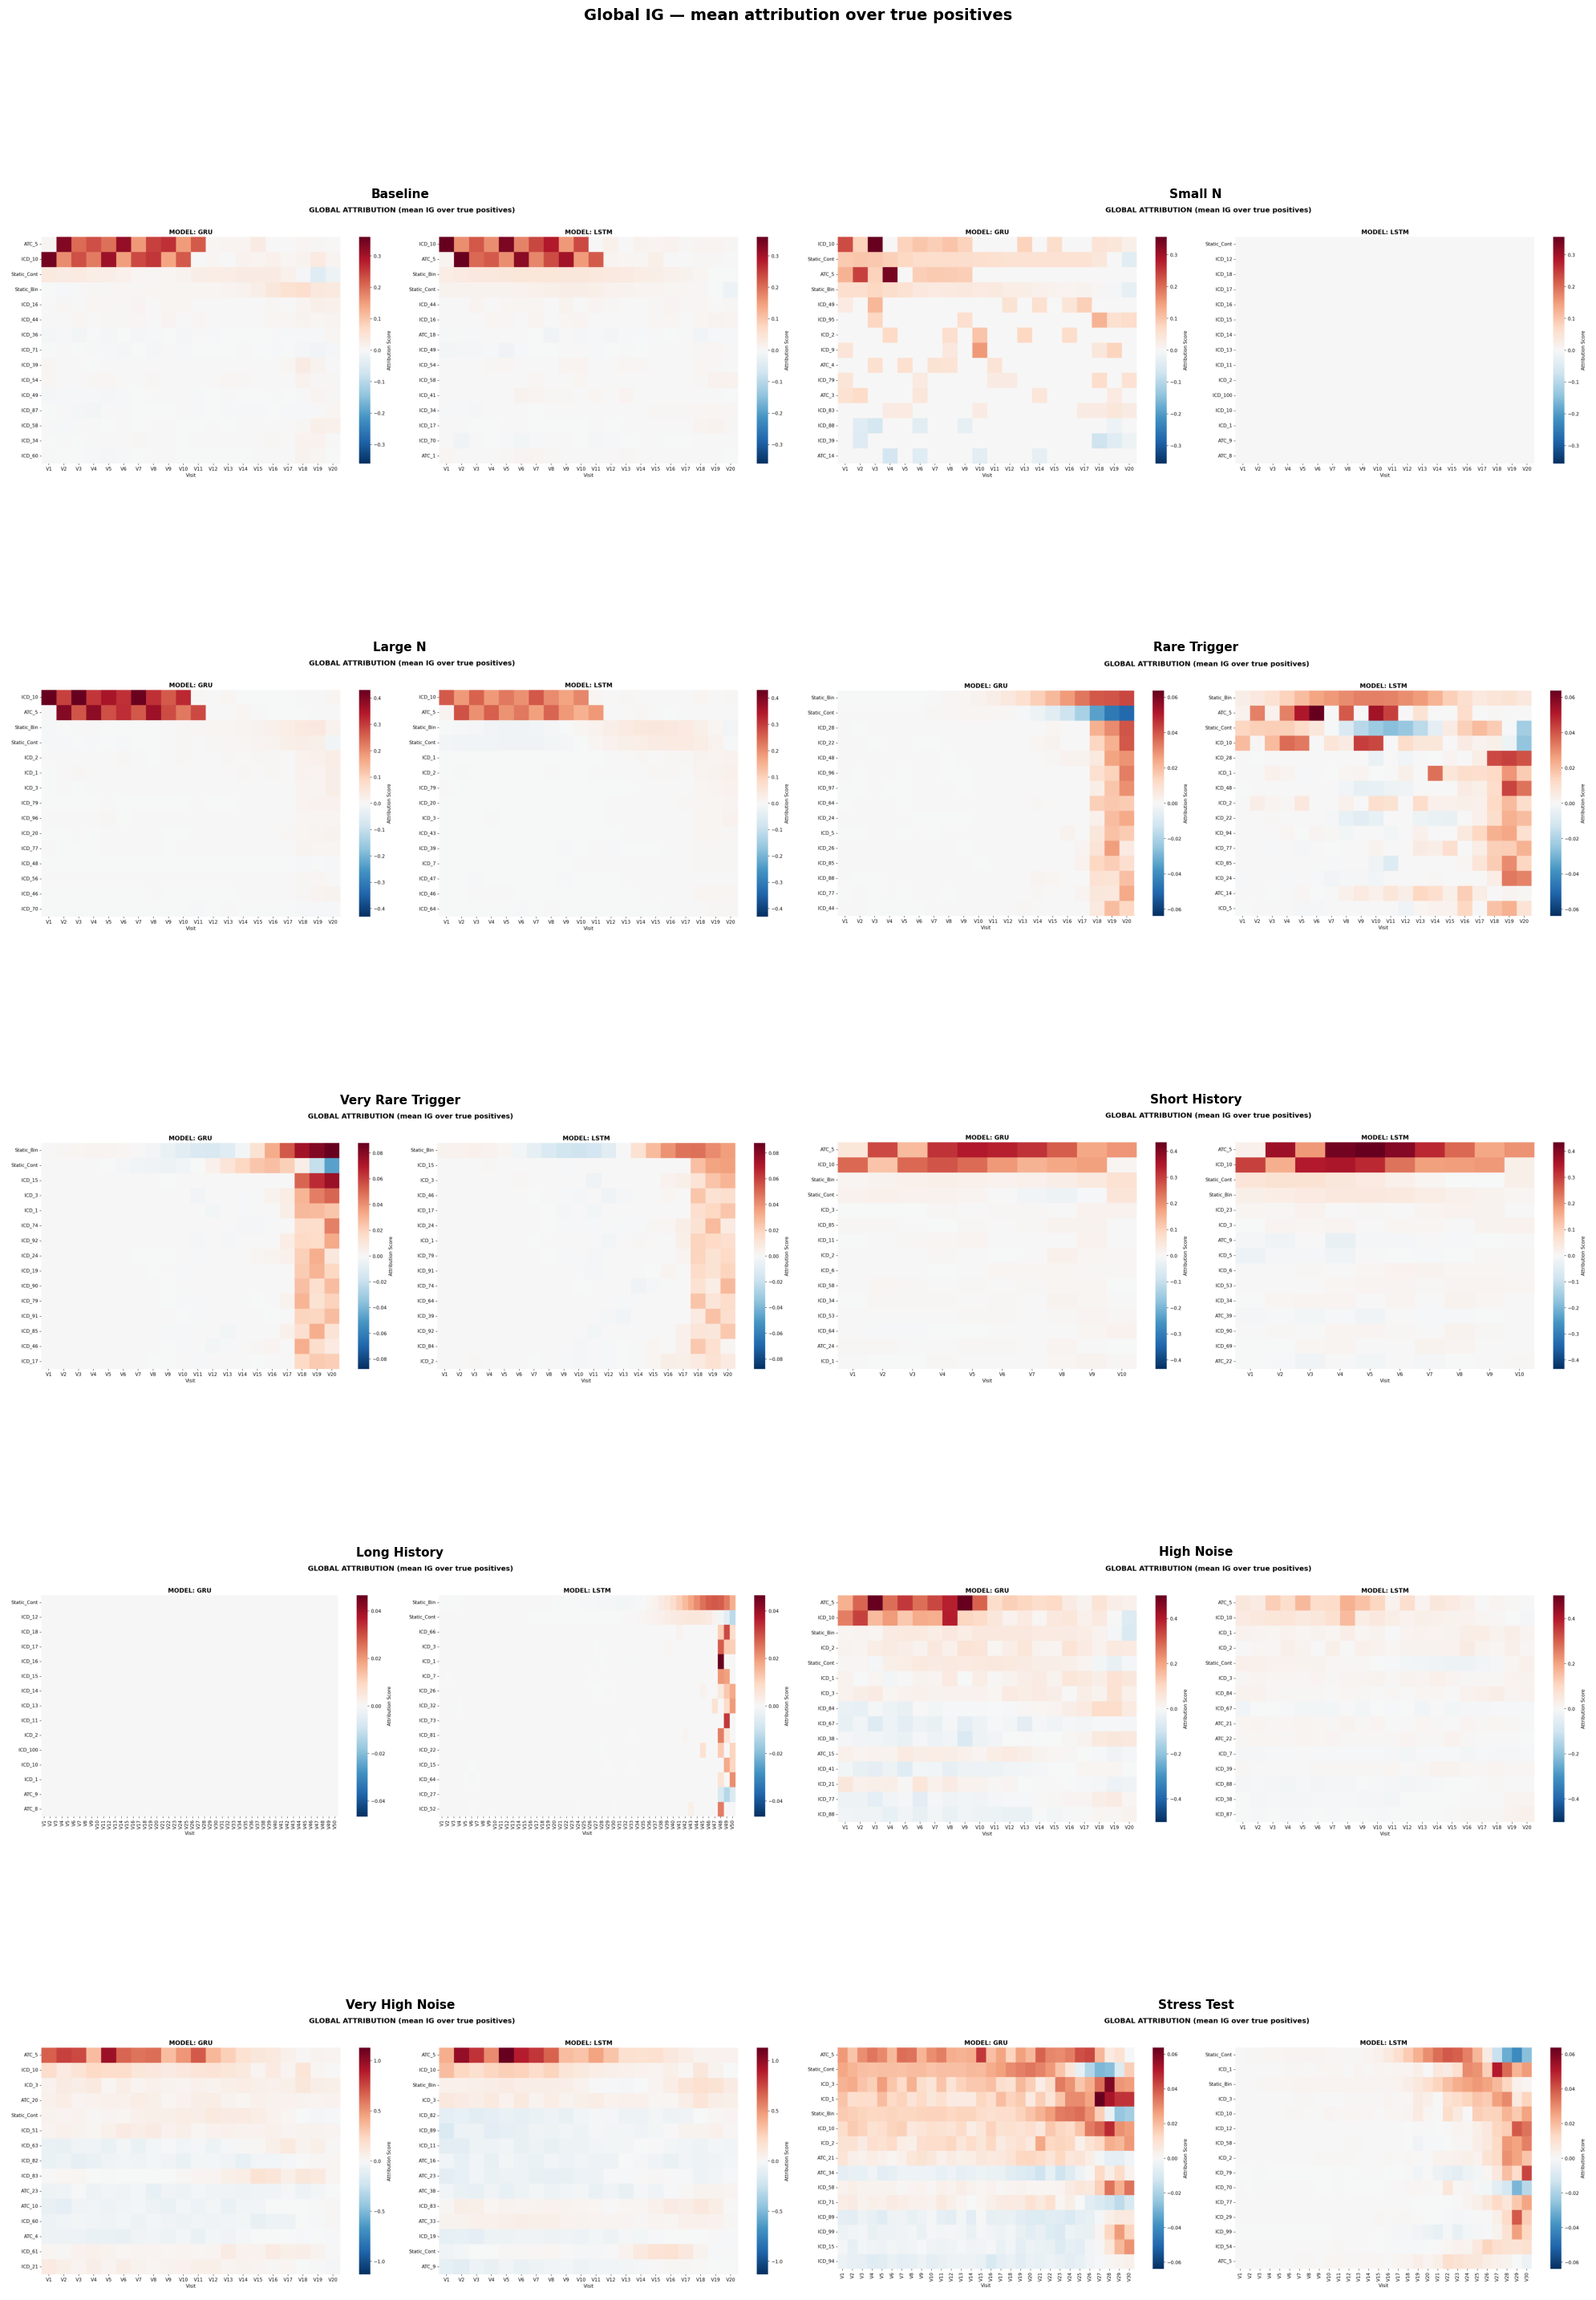

In [6]:
show_grid(
    [(sc_img(s, "ig_global_heatmap.png"), s) for s in SCENARIOS],
    ncols=2, figsize_per=(10, 6),
    suptitle="Global IG — mean attribution over true positives",
)

### 4.2 IG case studies

Select a phenotype case to compare across scenarios.

In [7]:
# All case-study slugs that exist across any scenario
all_slugs = set()
for s in SCENARIOS:
    for f in glob.glob(os.path.join(sc_dir(s), "ig_case_*.png")):
        all_slugs.add(os.path.basename(f))

print("Available case-study files:")
for slug in sorted(all_slugs):
    print(f"  {slug}")

Available case-study files:
  ig_case_False_Positive.png
  ig_case_Mixed_All_Three.png
  ig_case_Mixed_Chronic___Escalation.png
  ig_case_Mixed_Trigger___Chronic.png
  ig_case_Mixed_Trigger___Escalation.png
  ig_case_Pure_Chronic.png
  ig_case_Pure_Late_Escalation.png
  ig_case_Pure_Trigger.png


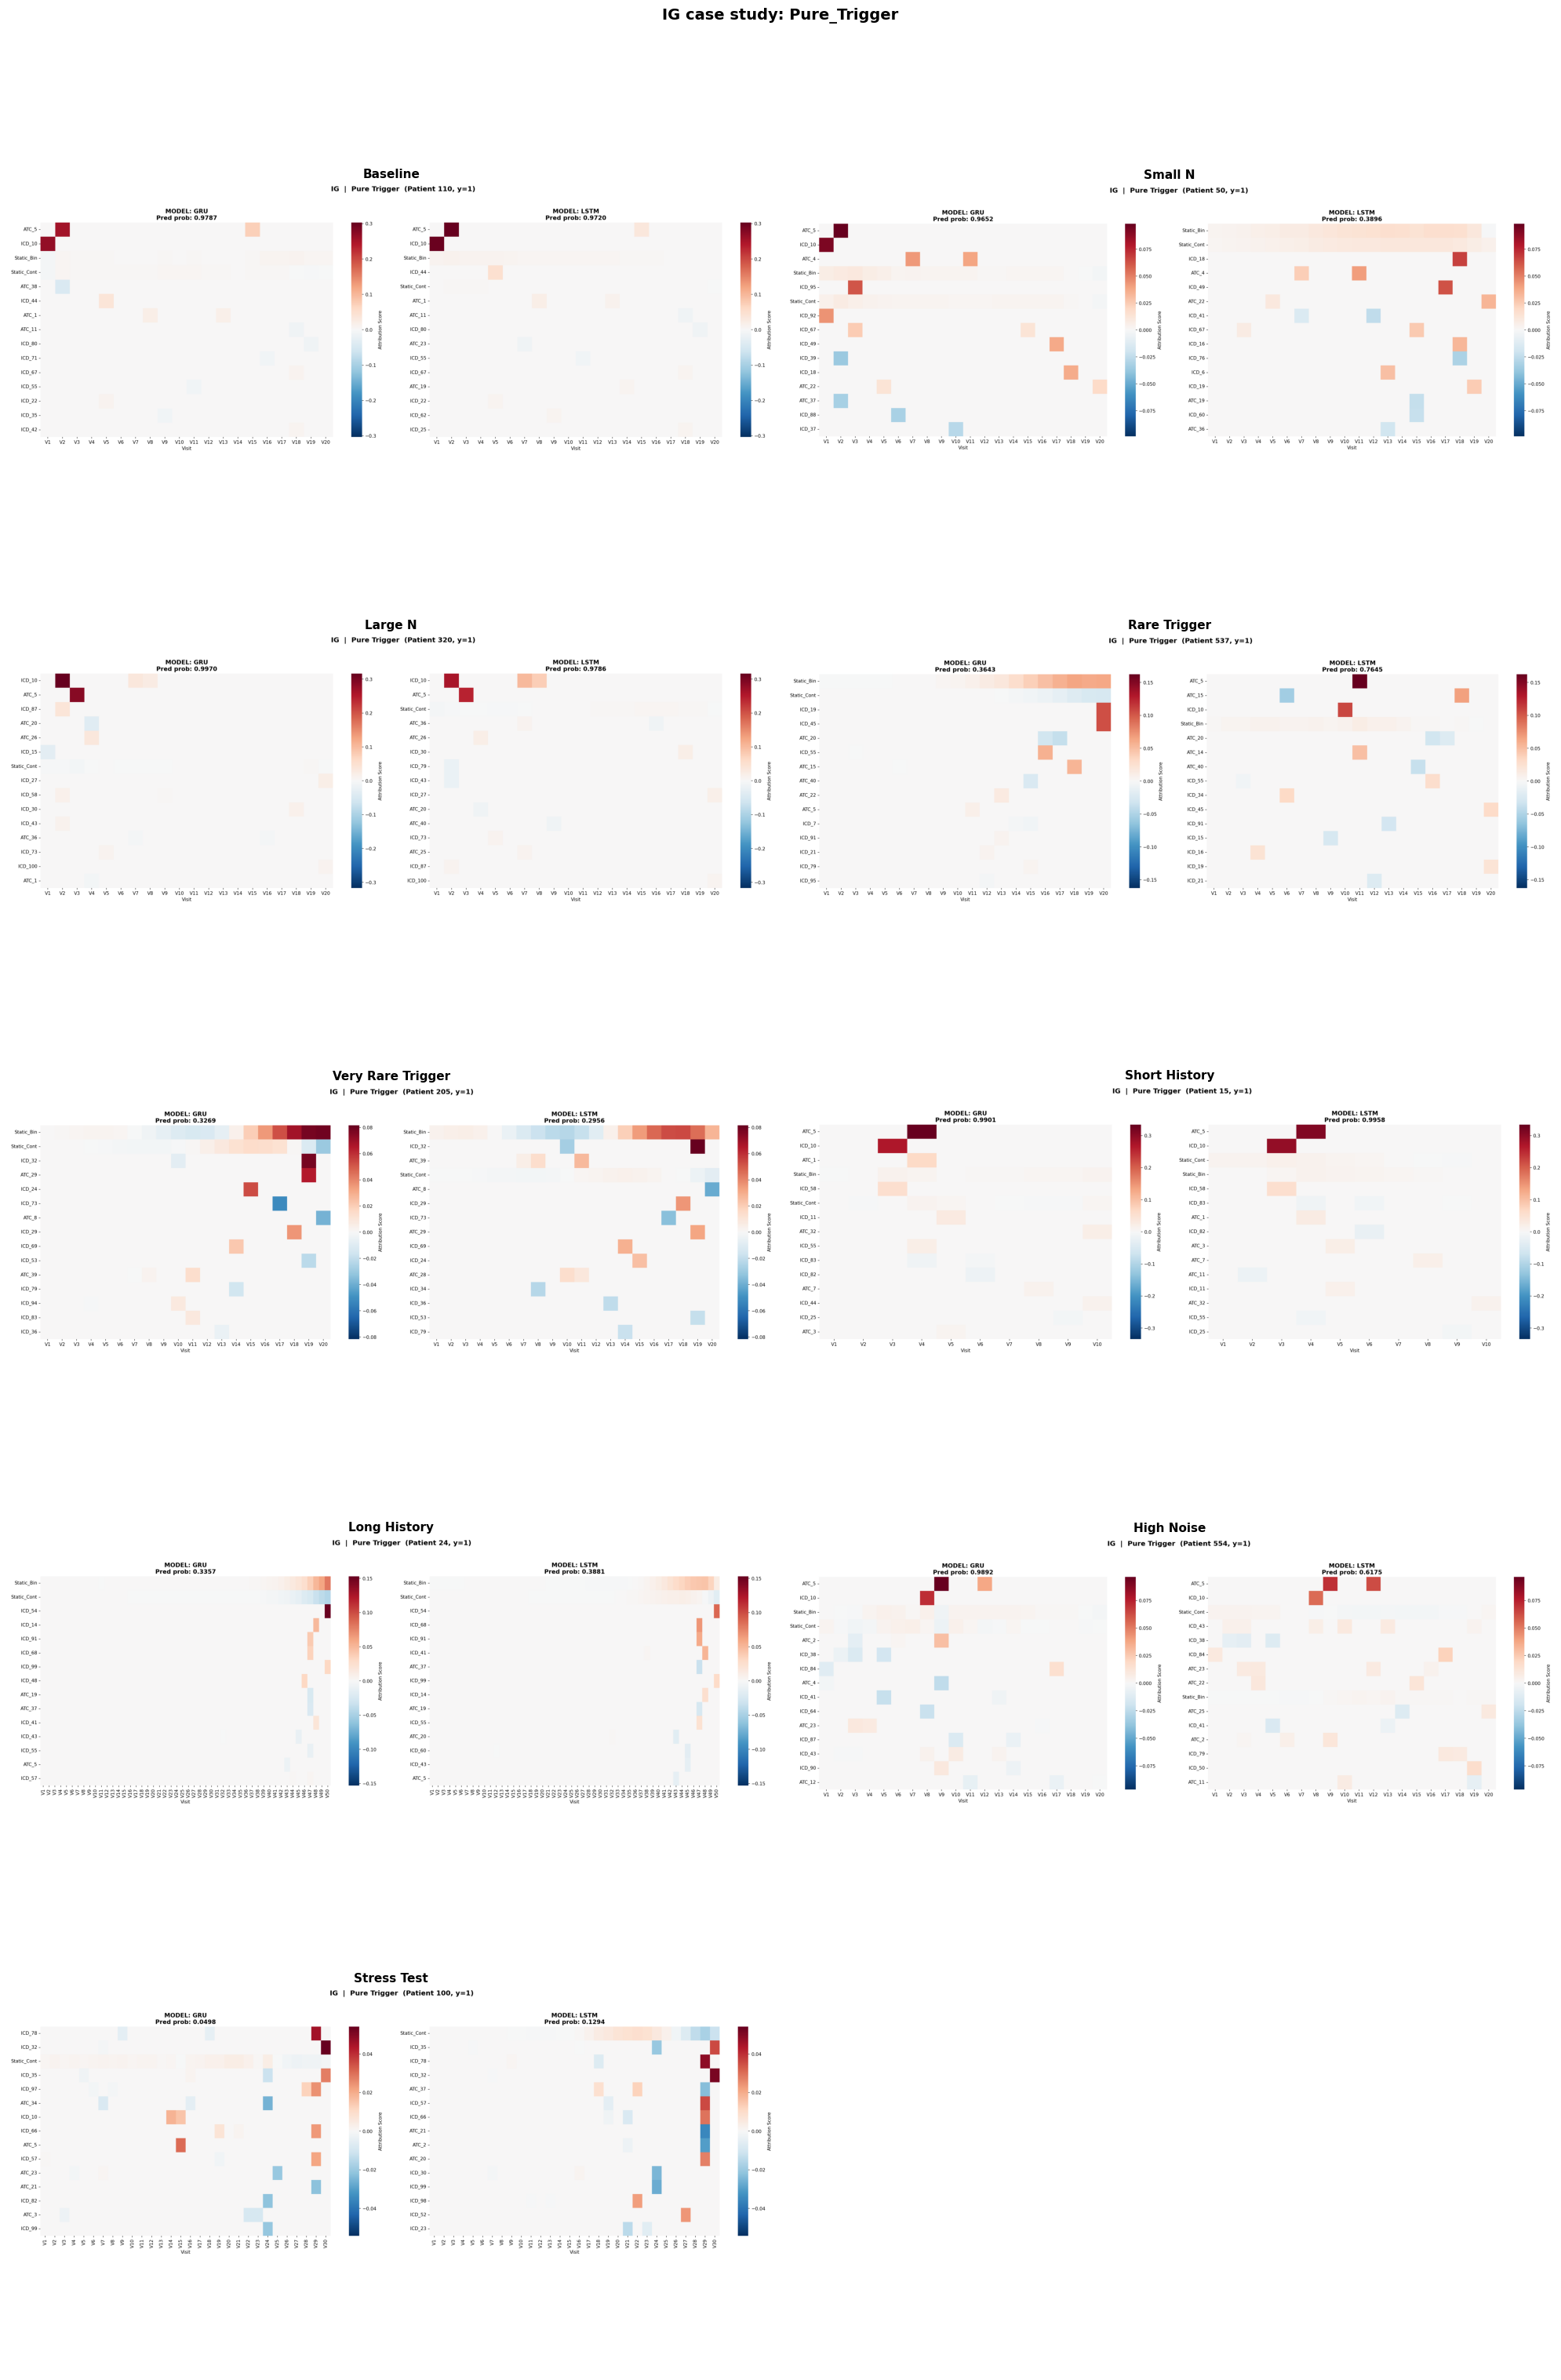

In [8]:
# ── Change slug here to compare a different case across scenarios ──────────────
CASE_SLUG = "ig_case_Pure_Trigger.png"   # ← set to any slug printed above

show_grid(
    [(sc_img(s, CASE_SLUG), s) for s in SCENARIOS],
    ncols=2, figsize_per=(10, 6),
    suptitle=f"IG case study: {CASE_SLUG.replace('ig_case_','').replace('.png','')}",
)

---
## 5. Expected Gradients (EG) — Global

### 5.1 Global importance & temporal plots

These were saved as inline plots, not PNGs, so we re-read the per-scenario EG attribution arrays and replot them here for comparison.

In [9]:
# EG attributions are not saved to disk by default in this pipeline version.
# To enable comparison, re-run a single scenario and capture eg_by_model,
# or add np.save() calls to run_eg_all_models() in utils.py.
#
# What IS saved: the cf_summary CSVs and benchmark CSVs.
# The cells below use those saved artefacts.

print("EG global plots require in-memory eg_by_model.")
print("If you have just run the pipeline, call the plotting functions directly:")
print("  utils.run_eg_global_plots(eg_by_model, X_test_np, feature_names)")

EG global plots require in-memory eg_by_model.
If you have just run the pipeline, call the plotting functions directly:
  utils.run_eg_global_plots(eg_by_model, X_test_np, feature_names)


### 5.2 Save EG arrays for later comparison (add to pipeline)

To unlock cross-scenario EG comparison without re-running, add these two lines to the pipeline loop right after `run_eg_all_models()`:

```python
for name, arr in eg_by_model.items():
    np.save(os.path.join(sc_out, f'eg_{name.lower()}.npy'), arr)
np.save(os.path.join(sc_out, 'X_test.npy'), X_test_np)
```

The cell below then loads and compares them automatically.

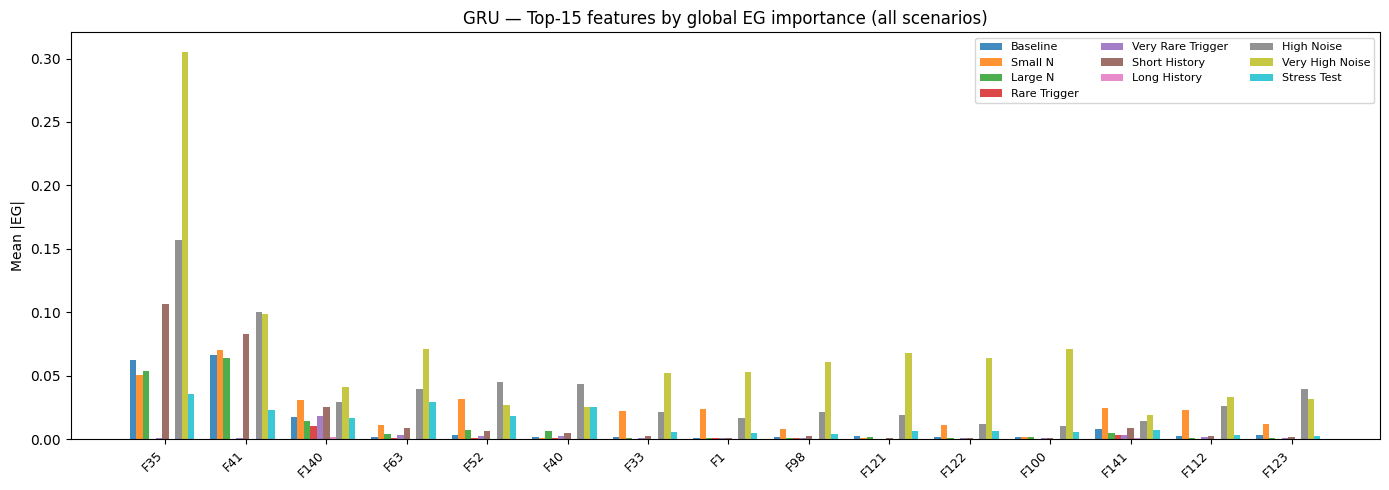

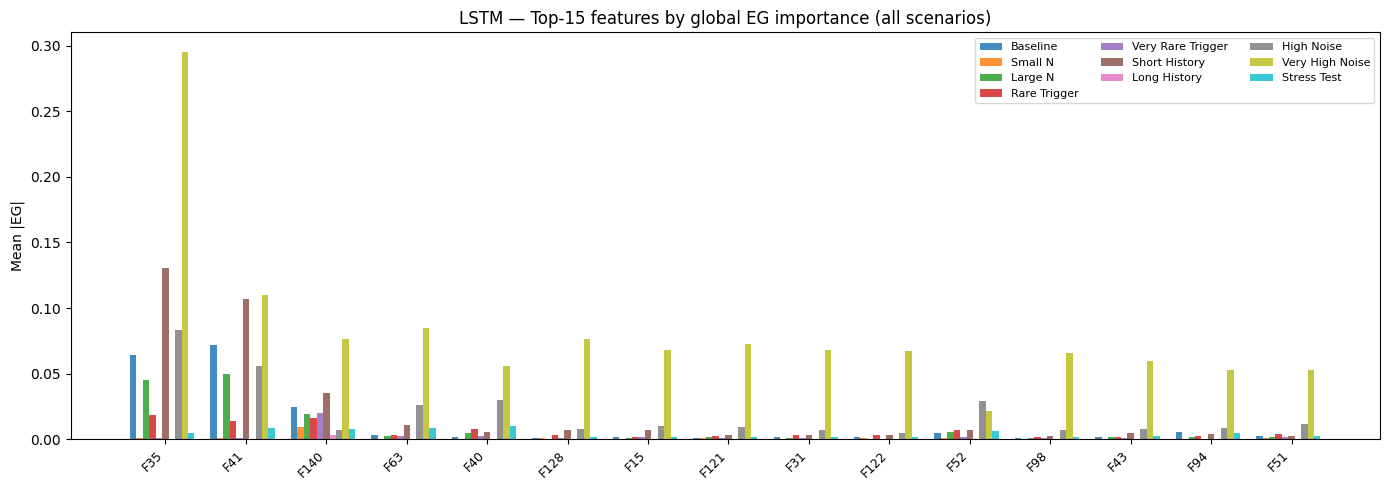

In [10]:
# Cross-scenario EG comparison — requires .npy files saved as described above

fig_rows = []
for model in MODELS:
    row_imps = {}
    for s in SCENARIOS:
        npy = os.path.join(sc_dir(s), f"eg_{model.lower()}.npy")
        feat_csv = os.path.join(sc_dir(s), "benchmark.csv")   # use as proxy to infer scenario ran
        if exists(npy):
            eg = np.load(npy)   # (N, T, F)
            row_imps[s] = np.mean(np.abs(eg), axis=(0, 1))    # (F,) global importance

    if not row_imps:
        print(f"{model}: no eg_*.npy files found — add np.save() to pipeline first")
        continue

    # Use the feature list from the first available scenario
    # (feature count may differ across scenarios if tokens differ)
    n_feats = min(len(v) for v in row_imps.values())
    mat = np.stack([v[:n_feats] for v in row_imps.values()])  # (scenarios, F)

    # Top-15 features by mean importance across scenarios
    top_idx = np.argsort(mat.mean(axis=0))[-15:][::-1]

    fig, ax = plt.subplots(figsize=(14, 5))
    x = np.arange(len(top_idx))
    width = 0.8 / len(row_imps)
    for i, (sc_name, imp) in enumerate(row_imps.items()):
        ax.bar(x + i * width, imp[top_idx], width=width, label=sc_name, alpha=0.85)
    ax.set_xticks(x + width * len(row_imps) / 2)
    ax.set_xticklabels([f"F{j}" for j in top_idx], rotation=45, ha="right", fontsize=9)
    ax.set_ylabel("Mean |EG|")
    ax.set_title(f"{model} — Top-15 features by global EG importance (all scenarios)")
    ax.legend(fontsize=8, ncol=3, loc="upper right")
    plt.tight_layout()
    plt.show()

---
## 6. EG Case Studies

Loads saved EG arrays and plots the chosen case study for every scenario side by side.

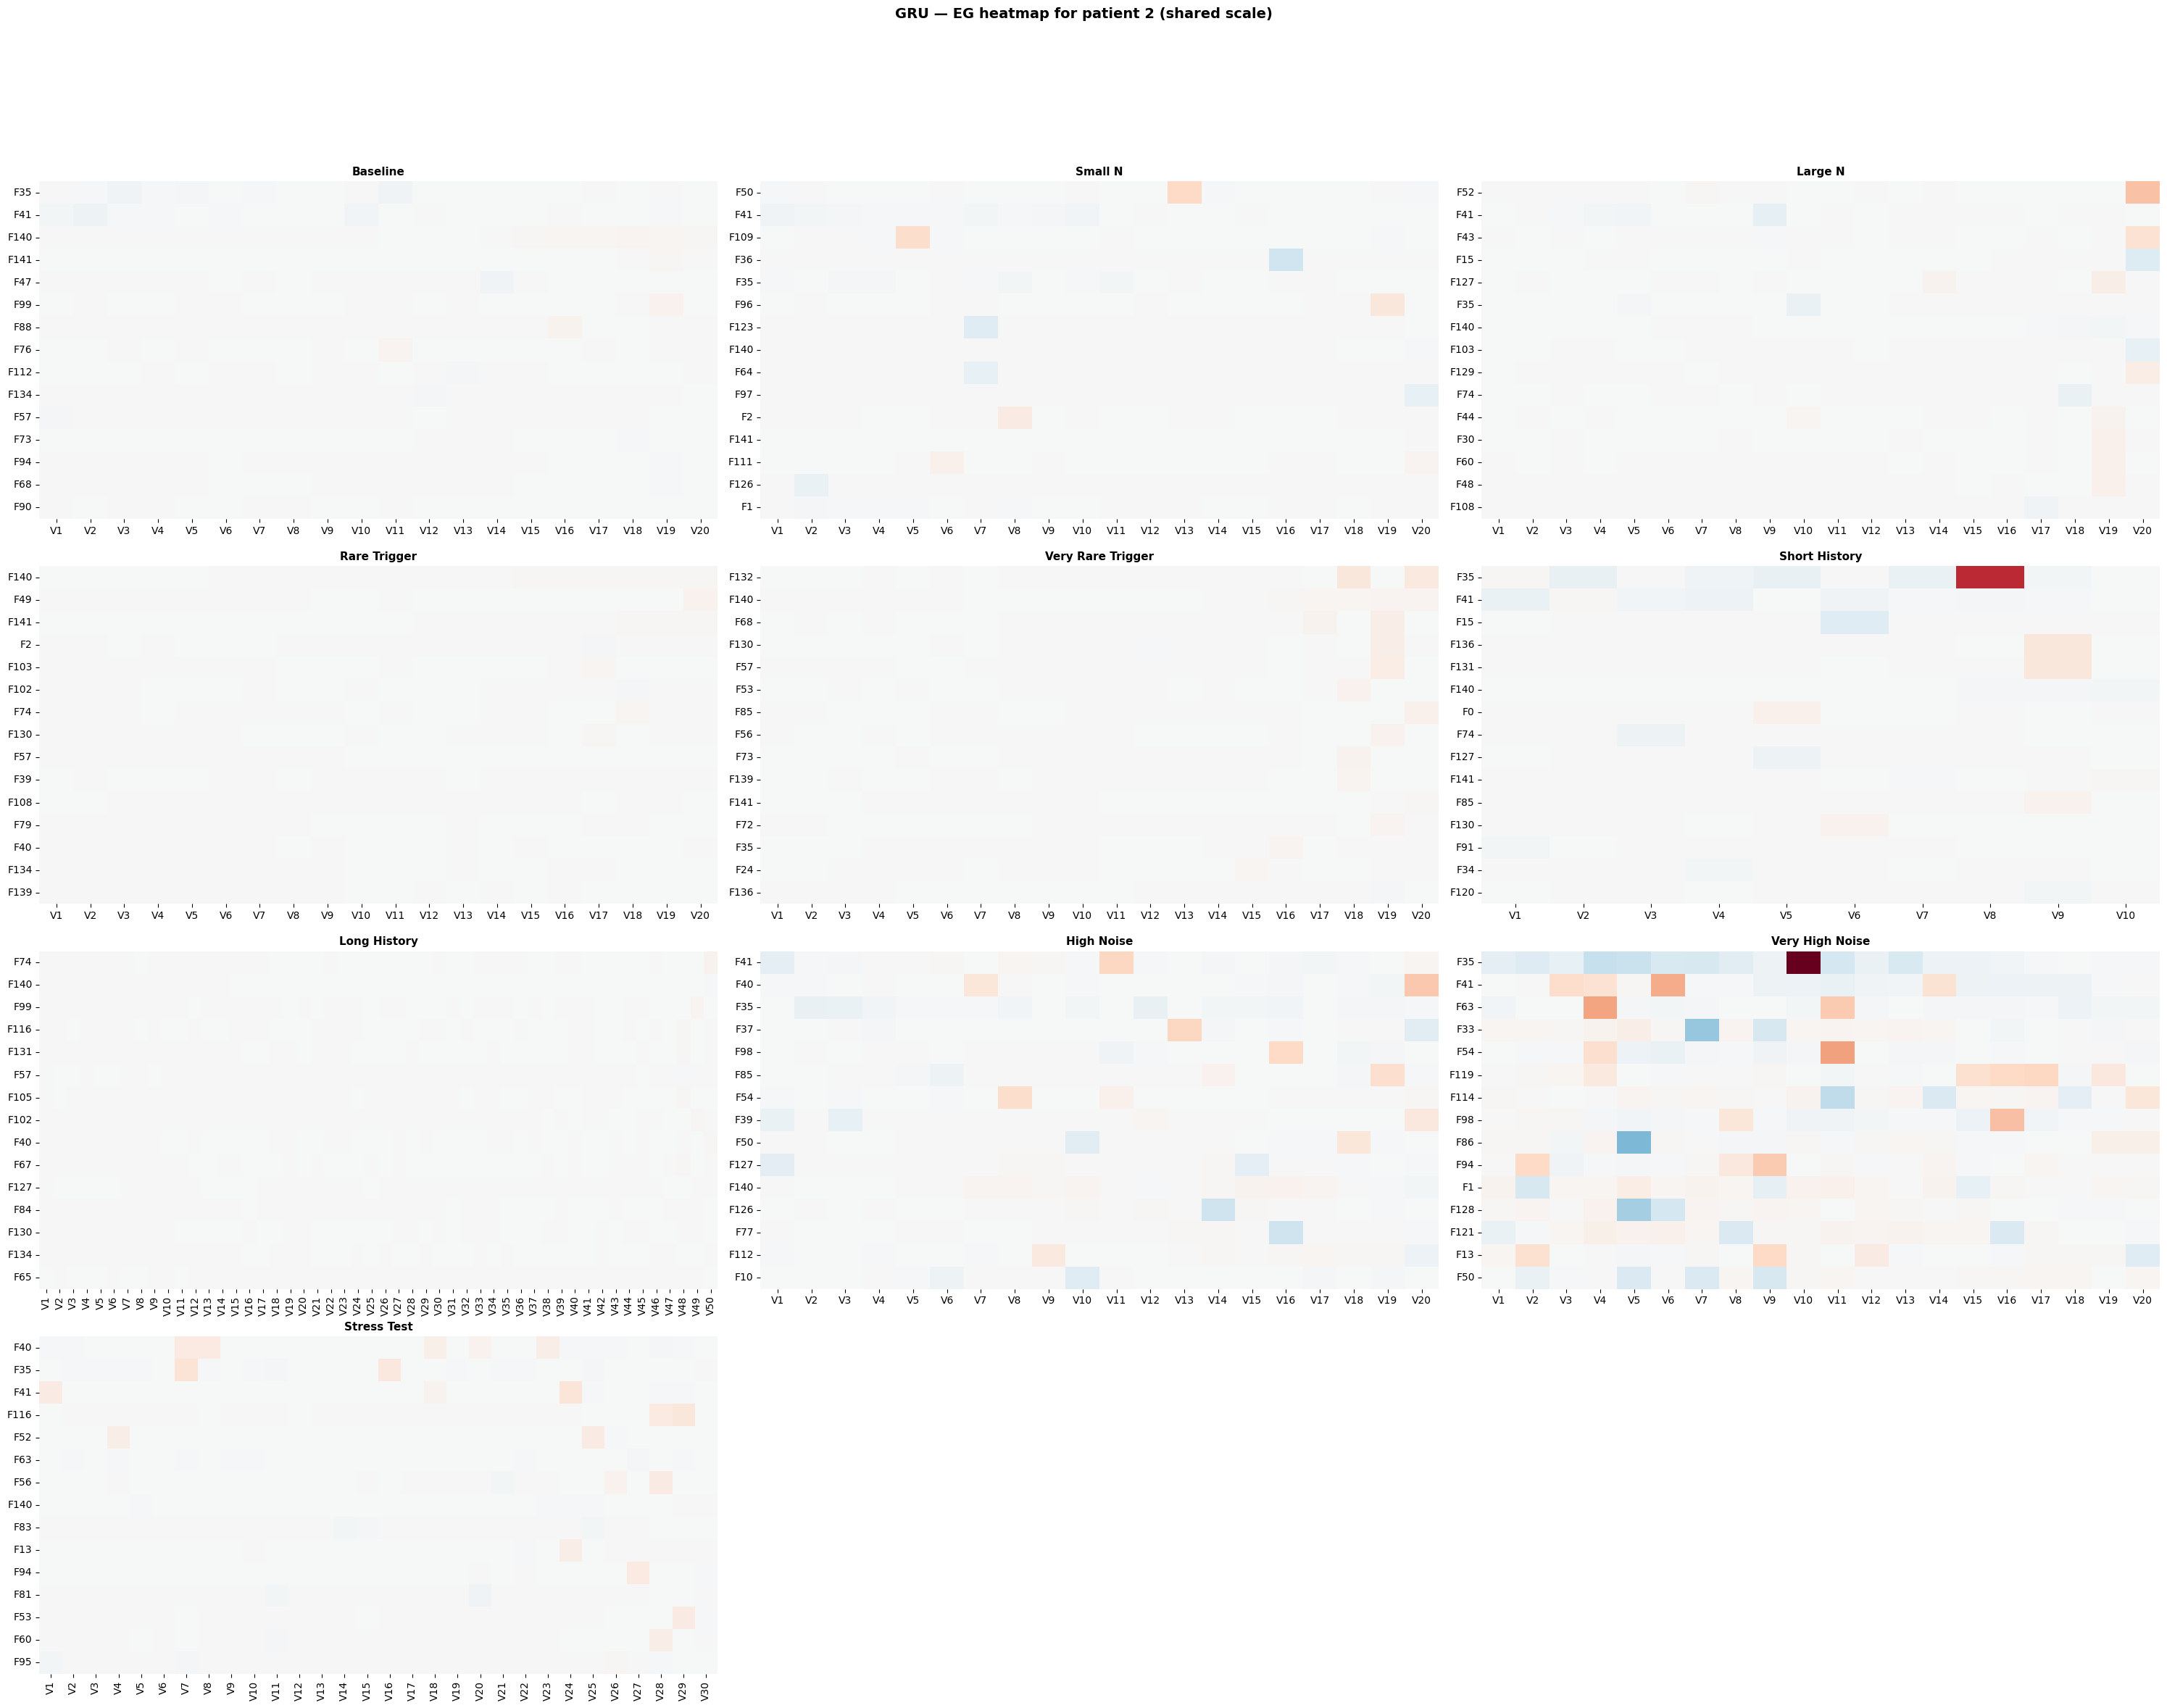

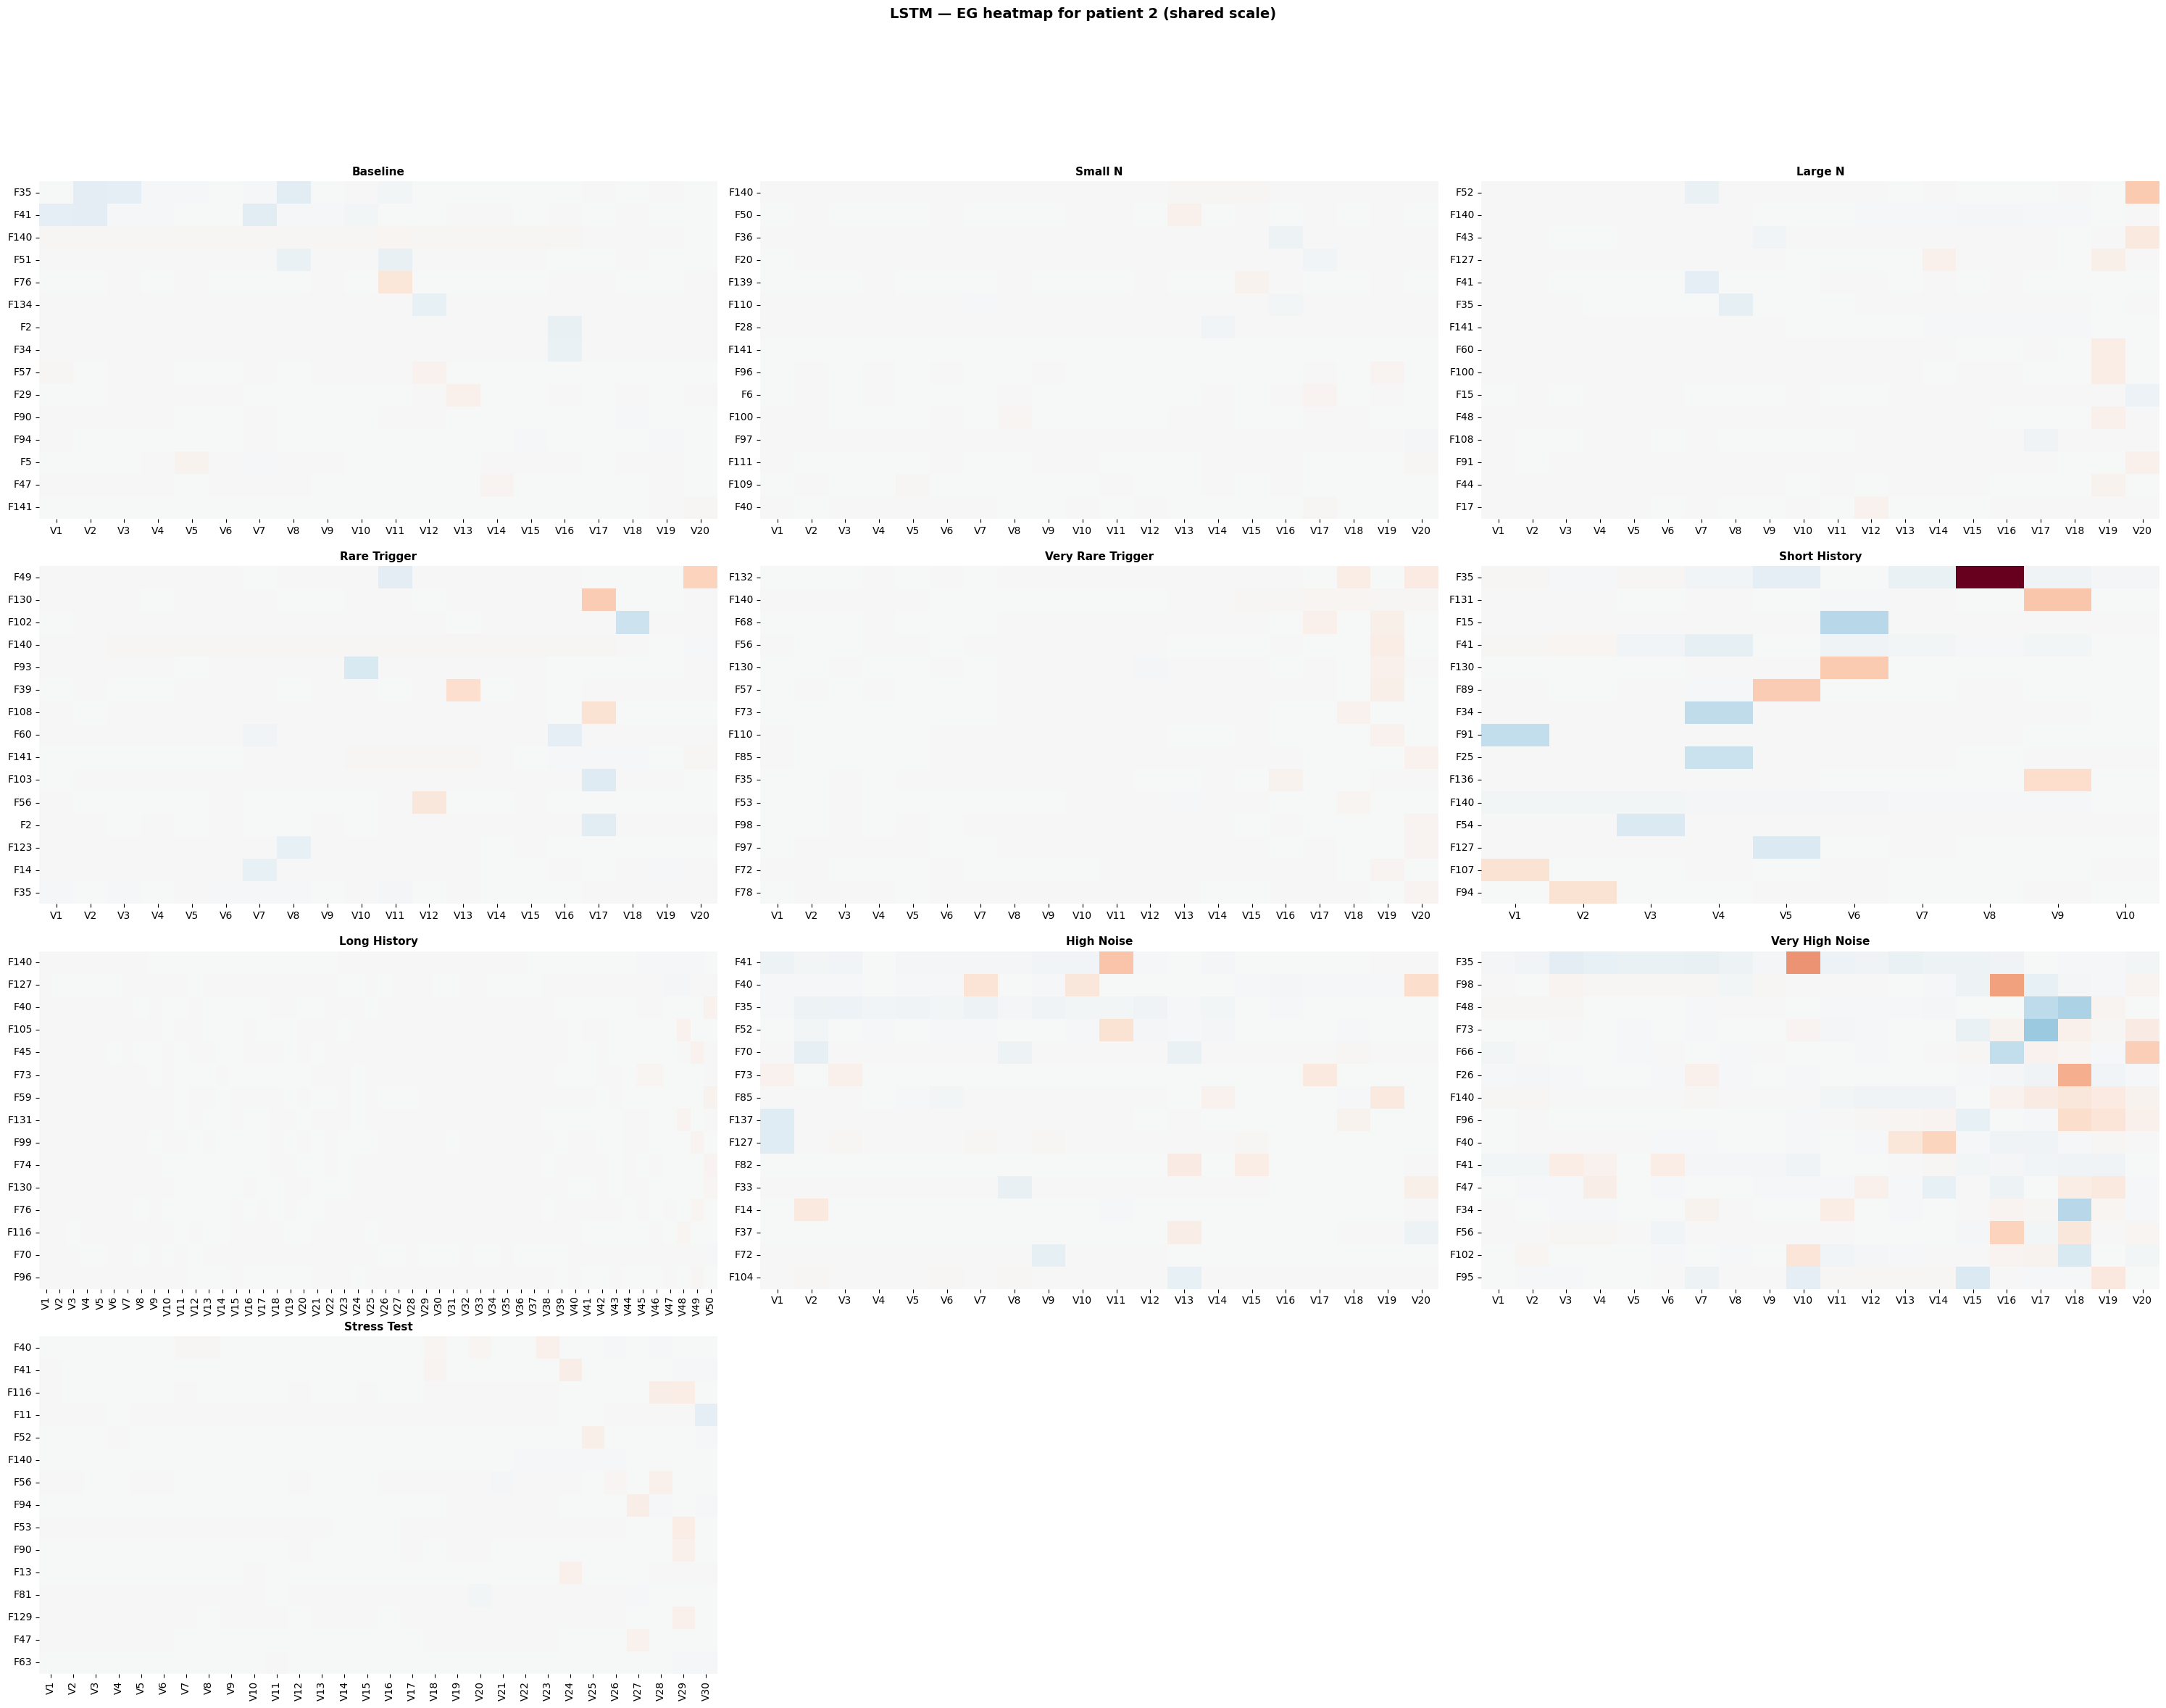

In [16]:
# Requires eg_*.npy and X_test.npy saved in each scenario folder (see §5.2)

CASE_PATIENT_IDX = 2    # ← test-set row index of the patient to show
TOP_K = 15

for model in MODELS:
    items = []
    for s in SCENARIOS:
        npy     = os.path.join(sc_dir(s), f"eg_{model.lower()}.npy")
        x_npy   = os.path.join(sc_dir(s), "X_test.npy")
        if not (exists(npy) and exists(x_npy)):
            continue
        eg  = np.load(npy)
        sv  = eg[CASE_PATIENT_IDX]         # (T, F)
        score   = np.mean(np.abs(sv), axis=0)
        top_idx = np.argsort(score)[::-1][:TOP_K]
        vmax    = np.max(np.abs(sv)) + 1e-12
        items.append((s, sv, top_idx, vmax))

    if not items:
        print(f"{model}: no .npy files found")
        continue

    shared_vmax = max(v for _, _, _, v in items)
    ncols = min(3, len(items))
    nrows = -(-len(items) // ncols)
    fig, axes = plt.subplots(nrows, ncols,
                              figsize=(10*ncols, 6*nrows))
    axes = np.array(axes).flatten()

    import seaborn as sns
    for ax, (s, sv, top_idx, _) in zip(axes, items):
        T = sv.shape[0]
        sns.heatmap(sv[:, top_idx].T, cmap="RdBu_r", center=0,
                    vmin=-shared_vmax, vmax=shared_vmax, ax=ax,
                    xticklabels=[f"V{t+1}" for t in range(T)],
                    yticklabels=[f"F{j}" for j in top_idx],
                    cbar=False)
        ax.set_title(s, fontsize=11, fontweight="bold")
    for ax in axes[len(items):]:
        ax.axis("off")
    fig.suptitle(f"{model} — EG heatmap for patient {CASE_PATIENT_IDX} (shared scale)",
                 fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

---
## 7. Counterfactual Explanations

### 7.1 Summary table — all scenarios & models

In [12]:
cf_rows = []
for s in SCENARIOS:
    for model in MODELS:
        csv = os.path.join(sc_dir(s), f"cf_summary_{model.lower()}.csv")
        if exists(csv):
            df = pd.read_csv(csv)
            df.insert(0, "Scenario", s)
            df.insert(1, "Model",    model)
            cf_rows.append(df)

if cf_rows:
    cf_all = pd.concat(cf_rows, ignore_index=True)
    cf_all.to_csv(os.path.join(OUT_DIR, "cf_summary_all.csv"), index=False)
    display(cf_all)
else:
    print("No cf_summary_*.csv files found.")

,Scenario,Model,Case,test_idx,patient_id,y_true,p_before,p_after,delta,crossed,n_edits,first_edit
0,Baseline,GRU,False Positive,567,1186,0,0.978279,0.974911,0.003368,False,4,ICD_54 @ t=19
1,Baseline,GRU,Mixed: All Three,513,113,1,0.979250,0.972252,0.006998,False,8,ICD_45 @ t=19
2,Baseline,GRU,Mixed: Chronic + Escalation,406,1640,1,0.972439,0.954562,0.017877,False,8,ICD_28 @ t=19
3,Baseline,GRU,Mixed: Trigger + Chronic,284,1739,1,0.979053,0.977543,0.001510,False,3,ICD_53 @ t=19
4,Baseline,GRU,Mixed: Trigger + Escalation,520,2519,1,0.977557,0.969577,0.007980,False,8,ICD_16 @ t=19
...,...,...,...,...,...,...,...,...,...,...,...,...
141,Stress Test,LSTM,Mixed: All Three,226,1391,1,0.706704,0.564613,0.142090,False,8,ICD_58 @ t=29
142,Stress Test,LSTM,Mixed: Chronic + Escalation,809,2020,1,0.615341,0.466768,0.148573,True,4,ICD_20 @ t=29
143,Stress Test,LSTM,Mixed: Trigger + Chronic,800,2902,1,0.405172,0.405172,0.000000,True,0,NaN
144,Stress Test,LSTM,Pure Chronic,77,1493,1,0.558209,0.465149,0.093060,True,2,ICD_1 @ t=27


### 7.2 Crossing rate — how often did CF succeed?

Model,GRU,LSTM
Scenario,,
Baseline,25%,12%
Small N,12%,100%
Large N,25%,25%
Rare Trigger,62%,38%
Very Rare Trigger,100%,100%
Short History,25%,25%
Long History,100%,100%
High Noise,38%,62%
Very High Noise,20%,40%


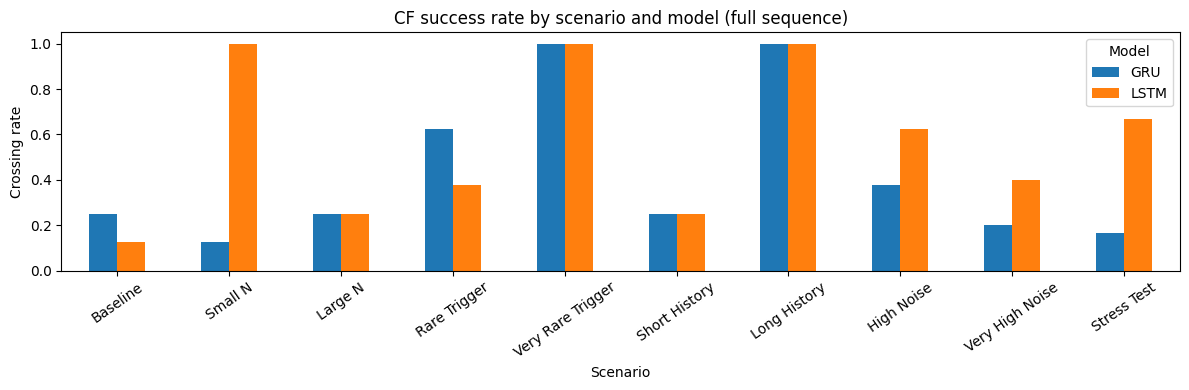

In [13]:
if cf_rows:
    cross_rate = (cf_all
                  .groupby(["Scenario", "Model"])["crossed"]
                  .mean()
                  .unstack("Model")
                  .round(3)
                  .reindex([s for s in SCENARIOS if s in cf_all["Scenario"].unique()]))

    display(cross_rate.style
            .background_gradient(cmap="YlGn", axis=None)
            .format("{:.0%}"))

    fig, ax = plt.subplots(figsize=(12, 4))
    cross_rate.plot(kind="bar", ax=ax, rot=35)
    ax.set_ylabel("Crossing rate")
    ax.set_title("CF success rate by scenario and model (full sequence)")
    ax.set_ylim(0, 1.05)
    ax.legend(title="Model")
    plt.tight_layout()
    plt.show()